In [ ]:
!pip install sagemaker --upgrade huggingface-hub diffusers torch transformers hf_transfer huggingface-hub sentencepiece accelerate

In [ ]:
import os
import boto3
import tarfile
import tempfile
import subprocess
import sagemaker

sess = sagemaker.Session()

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

In [ ]:
from pathlib import Path
import os
 
# set HF_HUB_ENABLE_HF_TRANSFER env var to enable hf-transfer for faster downloads
os.environ["HF_HUB_ENABLE_HF_TRANSFER"] = "1"
 
HF_MODEL_ID = "black-forest-labs/FLUX.1-dev"
# create model dir
model_tar_dir = Path(HF_MODEL_ID.split("/")[-1])
model_tar_dir.mkdir(exist_ok=True)
!mkdir code

In [ ]:
from huggingface_hub import snapshot_download
snapshot_download("Comfy-Org/flux1-dev",
                  local_dir='./flux_model',
                  local_dir_use_symlinks=False)

In [3]:
import torch
from diffusers import FluxPipeline, FluxTransformer2DModel

# Load the FP8 transformer
transformer = FluxTransformer2DModel.from_single_file(
    "flux_model/flux1-dev-fp8.safetensors",
)

In [ ]:
# Create the pipeline with the FP8 transformer
pipe = FluxPipeline.from_pretrained(
    "black-forest-labs/FLUX.1-dev",
    transformer=transformer,
)

In [ ]:
# Save pipeline in model dir
pipe.save_pretrained(save_directory=model_tar_dir)

In [ ]:
import gc
del pipe
gc.collect()

In [5]:
# Create code artifacts

In [8]:
%%writefile code/requirements.txt
diffusers==0.32.2
transformers==4.49.0
accelerate>=0.21.0
safetensors>=0.4.0
pillow>=10.0.0
protobuf
sentencepiece

Writing code/requirements.txt


In [9]:
%%writefile code/inference.py
import os
import io
import json
import base64
import torch
import gc
import logging
from diffusers import FluxPipeline
import huggingface_hub

# Configure logging
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("flux_inference")

def model_fn(model_dir):
    """
    Load the model from the model directory.
    This function is called by SageMaker when the container starts.
    """
    # Load the model using from_pretrained instead of from_single_file
    pipe = FluxPipeline.from_pretrained(
        model_dir,
        torch_dtype=torch.bfloat16
    )
    
    # Enable CPU offload for memory optimization
    pipe.enable_sequential_cpu_offload()
    
    return pipe

def input_fn(request_body, request_content_type):
    """
    Parse input data from the request.
    """
    logger.info("Processing JSON input")
    if isinstance(request_body, bytearray) or isinstance(request_body, bytes):
        logger.info("Converting bytearray/bytes to string")
        request_body = request_body.decode('utf-8')
        logger.info(f"Decoded request_body: {request_body[:100]}...")
        
    try:
        input_data = json.loads(request_body)
        logger.info(f"Parsed JSON input: {input_data}")
    except Exception as e:
        logger.error(f"Error parsing JSON: {e}")
        raise
    
    # Handle different input formats:
    # If input is in {inputs: ..., parameters: ...} format
    if "inputs" in input_data and "parameters" in input_data:
        logger.info("Found inputs/parameters format")
        # Extract prompt from inputs
        prompt = input_data["inputs"]
        logger.info(f"Prompt type: {type(prompt)}, value: {prompt}")
        
        if isinstance(prompt, bytearray) or isinstance(prompt, bytes):
            logger.info("Converting prompt from bytearray/bytes to string")
            prompt = prompt.decode('utf-8')
            
        # Create a new input dictionary with the prompt and parameters
        result = {
            "prompt": prompt,
            **input_data["parameters"]
        }
        logger.info(f"Returning combined input data: {result}")
        return result
        
    # Otherwise, use the input data directly
    logger.info(f"Using direct input format: {input_data}")
    return input_data

def predict_fn(input_data, model):
    """
    Generate the image based on the input prompt.
    """
    logger.info("predict_fn called")
    logger.info(f"Input data: {input_data}")
    
    pipe = model
    
    # Extract parameters from the input with defaults
    prompt = input_data.get("prompt", "a beautiful landscape")
    logger.info(f"Extracted prompt: {prompt} (type: {type(prompt)})")
    
    # Ensure prompt is a string
    if isinstance(prompt, bytearray) or isinstance(prompt, bytes):
        logger.info("Converting prompt from bytearray/bytes to string")
        prompt = prompt.decode('utf-8')
        logger.info(f"Converted prompt: {prompt}")
        
    guidance_scale = float(input_data.get("guidance_scale", 3.5))
    height = int(input_data.get("height", 768))
    width = int(input_data.get("width", 1360))
    num_inference_steps = int(input_data.get("num_inference_steps", 3))
    
    logger.info(f"Parameters: guidance_scale={guidance_scale}, height={height}, width={width}, steps={num_inference_steps}")
    
    # Additional optional parameters
    negative_prompt = input_data.get("negative_prompt", None)
    logger.info(f"Negative prompt: {negative_prompt} (type: {type(negative_prompt) if negative_prompt else None})")
    
    if negative_prompt is not None and (isinstance(negative_prompt, bytearray) or isinstance(negative_prompt, bytes)):
        logger.info("Converting negative_prompt from bytearray/bytes to string")
        negative_prompt = negative_prompt.decode('utf-8')
        
    seed = input_data.get("seed", None)
    logger.info(f"Seed: {seed}")
    
    # Set seed if provided
    generator = None
    if seed is not None:
        logger.info(f"Setting generator with seed: {seed}")
        generator = torch.Generator().manual_seed(int(seed))
    
    # Generate the image
    logger.info("Calling Flux pipeline")
    try:
        output = pipe(
            prompt=prompt,
            negative_prompt=negative_prompt,
            guidance_scale=guidance_scale,
            height=height,
            width=width,
            num_inference_steps=num_inference_steps,
            generator=generator,
        )
        logger.info("Image generation successful")
    except Exception as e:
        logger.error(f"Error generating image: {e}")
        raise
    
    # Get the first image (assuming batch size of 1)
    image = output.images[0]
    logger.info(f"Image dimensions: {image.width}x{image.height}")
    
    # Convert to base64 string
    try:
        buffered = io.BytesIO()
        image.save(buffered, format="PNG")
        img_str = base64.b64encode(buffered.getvalue()).decode()
        logger.info(f"Base64 encoded image length: {len(img_str)}")
    except Exception as e:
        logger.error(f"Error encoding image: {e}")
        raise
    
    # Return the image and metadata
    result = {
        "image": img_str,
        "parameters": {
            "prompt": prompt,
            "guidance_scale": guidance_scale,
            "height": height,
            "width": width,
            "steps": num_inference_steps,
            "seed": seed
        }
    }
    logger.info("Returning result with image and parameters")
    return result

def output_fn(prediction, response_content_type):
    """Format the prediction output."""
    logger.info(f"output_fn called with content_type: {response_content_type}")
    logger.info(f"Prediction contains image: {'image' in prediction}")
    
    if response_content_type == 'application/json':
        logger.info("Returning JSON response")
        try:
            json_result = json.dumps(prediction)
            logger.info(f"JSON response length: {len(json_result)}")
            return json_result, response_content_type
        except Exception as e:
            logger.error(f"Error serializing to JSON: {e}")
            raise
    else:
        # Return just the base64 image for non-JSON requests
        logger.info("Returning plain text response (image only)")
        gc.collect()
        return prediction["image"], "text/plain"

Writing code/inference.py


In [ ]:
import shutil

# Move the file
shutil.move('code', model_tar_dir)

In [12]:
import os
parent_dir=os.getcwd()
# change to model dir
os.chdir(str(model_tar_dir))
# use pigz for faster and parallel compression
!tar -cf model.tar.gz --use-compress-program=pigz *
# change back to parent dir
os.chdir(parent_dir)

In [ ]:
from sagemaker.s3 import S3Uploader

# upload model.tar.gz to s3
s3_model_uri = S3Uploader.upload(local_path=str(model_tar_dir.joinpath("model.tar.gz")), desired_s3_uri=f"s3://{sess.default_bucket()}/flux-fp8-pipe")

print(f"model uploaded to: {s3_model_uri}")

In [14]:
import os
import boto3
import sagemaker
from sagemaker.pytorch import PyTorchModel
from sagemaker import get_execution_role

# Get SageMaker execution role
role = get_execution_role()
session = sagemaker.Session()

# Configuration parameters
model_name = "flux-image-generator"
instance_type = "ml.g5.8xlarge"

# Create PyTorch model with custom inference code
model = PyTorchModel(
    model_data=s3_model_uri,
    role=role,
    framework_version="2.5",
    py_version="py311",   # Must match Python version of your custom wheels
)

In [ ]:
# Deploy the model to an endpoint
predictor = model.deploy(
    initial_instance_count=1,
    instance_type=instance_type,
    endpoint_name=f"{model_name}-endpoint"
)

print(f"Model deployed successfully to endpoint: {predictor.endpoint_name}")

In [ ]:
# Use the boto3 runtime client directly for more control
import boto3
import json

# Create runtime client
runtime = boto3.client('runtime.sagemaker')

# Create a simplified payload - just a string prompt
payload = json.dumps({"prompt": "a tiny astronaut hatching from an egg on the moon", "num_inference_steps": 10})

# Make the direct call
response = runtime.invoke_endpoint(
    EndpointName="flux-image-generator-endpoint",
    ContentType="application/json",
    Body=payload
)

response

[03/18/25 20:01:39] WARNING  Matplotlib is building the font cache; this may take a moment.    ]8;id=619348;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=929668;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py#1095\1095]8;;\

[03/18/25 20:01:41] INFO     generated new fontManager                                         ]8;id=108218;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py\font_manager.py]8;;\:]8;id=385951;file:///home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/matplotlib/font_manager.py#1639\1639]8;;\

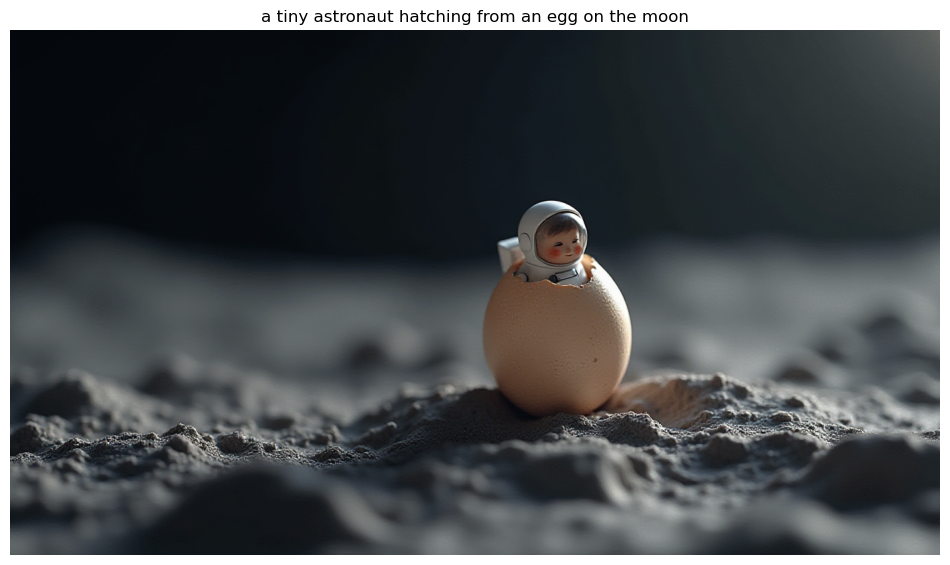

Image saved to generated_image.png
Parameters used:
- prompt: a tiny astronaut hatching from an egg on the moon
- guidance_scale: 3.5
- height: 768
- width: 1360
- steps: 10
- seed: None


In [17]:
import base64
import io
import json
from PIL import Image
import matplotlib.pyplot as plt

# Assuming 'response' is the variable containing the response object you showed
def display_sagemaker_image(response):
    # Read the streaming body content
    response_body = response["Body"].read().decode("utf-8")

    # Parse JSON from the response body
    response_data = json.loads(response_body)
    
    # Check if 'image' is in the parsed response
    if "image" not in response_data:
        raise KeyError("'image' key not found in the response")
    
    # Extract the base64-encoded image
    base64_img = response_data["image"]
    
    # Decode the base64 string
    img_bytes = base64.b64decode(base64_img)
    
    # Create a BytesIO object from the decoded bytes
    img_buffer = io.BytesIO(img_bytes)
    
    # Open the image using PIL
    img = Image.open(img_buffer)
    img.save("output_image.png")
    
    # Display the image using matplotlib
    plt.figure(figsize=(12, 10))
    plt.imshow(img)
    plt.axis('off')  # Hide the axes
    
    # Display the prompt if available
    if "parameters" in response_data and "prompt" in response_data["parameters"]:
        plt.title(response_data["parameters"]["prompt"])
    
    plt.show()
    
    # Optionally save the image
    img.save("generated_image.png")
    print(f"Image saved to generated_image.png")
    
    # Print parameters if available
    if "parameters" in response_data:
        print("Parameters used:")
        for key, value in response_data["parameters"].items():
            print(f"- {key}: {value}")
    
    return img

# Use the function with your response
image = display_sagemaker_image(response)